<a href="https://colab.research.google.com/github/Iman-Kalyan-Majumder/FYP/blob/main/HM_Alternative.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [6]:
import pandas as pd
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

In [4]:
data = pd.read_csv('BridgeMetrics.csv').drop('Unnamed: 0', axis=1)
data.head()

,Max,Min,Mean,Median,Std,PeakToPeak,Mode,Healthy
0,0.168,-0.192,-0.016880,-0.024,0.063430,0.360,-0.040,0
1,0.168,-0.192,-0.016880,-0.024,0.063430,0.360,-0.040,0
2,0.144,-0.176,0.001216,0.008,0.061272,0.320,0.032,1
3,0.128,-0.208,-0.019584,-0.016,0.063845,0.336,-0.024,1
4,0.128,-0.176,-0.015600,-0.016,0.061276,0.304,-0.024,1


In [5]:
X, y = data.drop('Healthy', axis=1), data['Healthy']

In [8]:
X_train, X_temp, y_train, y_temp = train_test_split(X,y, test_size=0.3, shuffle=True, random_state=42)
X_test, X_valid, y_test, y_valid = train_test_split(X_temp, y_temp, test_size=0.5, shuffle=True, random_state=42)

In [29]:
model = tf.keras.Sequential([
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dense(8, activation='relu'),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dense(16, activation='relu'),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dense(8, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

In [30]:
model.compile(
    tf.keras.optimizers.Adam(learning_rate=0.01),
    loss='binary_crossentropy',
    metrics=['accuracy']
)

In [31]:
early_stopping =tf.keras.callbacks.EarlyStopping(
    patience=50,
    min_delta=0.01,
    restore_best_weights=True
)

In [32]:
history = model.fit(
    X_train,
    y_train,
    batch_size=32,
    epochs=200,
    validation_data=(X_valid, y_valid),
    callbacks=[early_stopping]
)

Epoch 1/200
30/30 [==============================] - 3s 12ms/step - loss: 0.5768 - accuracy: 0.6751 - val_loss: 0.7085 - val_accuracy: 0.5196
Epoch 2/200
30/30 [==============================] - 0s 4ms/step - loss: 0.5341 - accuracy: 0.6930 - val_loss: 0.6921 - val_accuracy: 0.5196
Epoch 3/200
30/30 [==============================] - 0s 4ms/step - loss: 0.5231 - accuracy: 0.7036 - val_loss: 0.6684 - val_accuracy: 0.5196
Epoch 4/200
30/30 [==============================] - 0s 4ms/step - loss: 0.5242 - accuracy: 0.6983 - val_loss: 0.7073 - val_accuracy: 0.4804
Epoch 5/200
30/30 [==============================] - 0s 4ms/step - loss: 0.5341 - accuracy: 0.6962 - val_loss: 0.7034 - val_accuracy: 0.4804
Epoch 6/200
30/30 [==============================] - 0s 4ms/step - loss: 0.5240 - accuracy: 0.7025 - val_loss: 0.7074 - val_accuracy: 0.4902
Epoch 7/200
30/30 [==============================] - 0s 4ms/step - loss: 0.5279 - accuracy: 0.6994 - val_loss: 0.6568 - val_accuracy: 0.6275
Epoch 8/200


In [33]:
model.evaluate(X_test, y_test)

7/7 [==============================] - 0s 3ms/step - loss: 0.4739 - accuracy: 0.7833


[0.473916232585907, 0.7832512259483337]

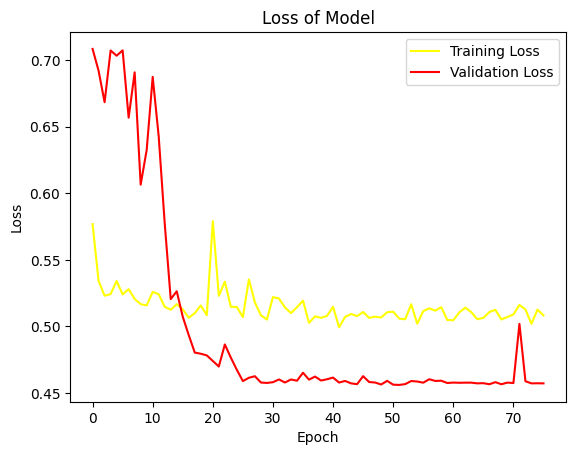

In [34]:
plt.plot(history.history['loss'], label='Training Loss', color='yellow')
plt.plot(history.history['val_loss'], label='Validation Loss', color='red')
plt.title("Loss of Model")
plt.ylabel("Loss")
plt.xlabel("Epoch")
plt.legend()
plt.show()